# IBM 推荐系统




## 目录

I. [探索性数据分析](#Exploratory-Data-Analysis)<br>
II.[基于排名的推荐方法](#Rank)<br>
III.[基于用户-用户的协同过滤](#User-User)<br>
IV. [矩阵分解](#Matrix-Fact)<br>
V.[其他内容和总结](#conclusions)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">第一部分：探索性数据分析</a>



`1.` 用户与数据集中的多少篇文章互动了？分布如何？以图表的形式描述每个用户与某篇文章互动的次数。

In [3]:
user_total_interact = df.groupby('email').count()['article_id']

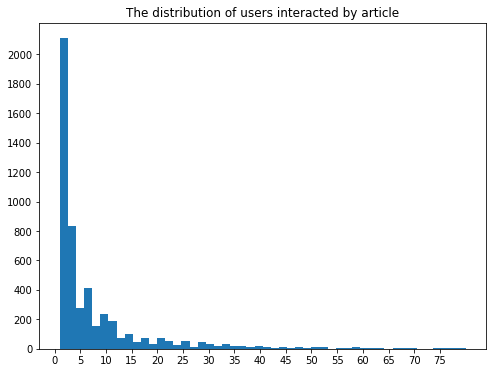

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(user_total_interact, bins=50, range=(1, 80))
plt.xticks(np.arange(0, 80, 5))
plt.yticks(np.arange(0, 2200, 200))
plt.title('The distribution of users interacted by article');

In [5]:
user_total_interact.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [6]:
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` 发现并移除 **df_content** dataframe 中的重复文章。

In [7]:
# Find and explore duplicate articles
df_content.duplicated(['article_id']).sum()

5

In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [9]:
df_content.duplicated(['article_id']).sum()

0

`3.` 在以下单元格中查找：

**a.**用户与之互动的唯一文章数量。  
**b.**数据集中的唯一文章数量（无论用户是否与之互动了）。<br>
**c.**数据集中的唯一用户数量。（不包括空值）<br>
**d.**数据集中的用户-文章互动次数。

In [10]:
len(pd.Series.unique(df['article_id']))


714

In [11]:
df_content.shape[0]

1051

In [12]:
df.email.dropna().unique().shape[0]

5148

In [13]:
df.shape[0]

45993

In [14]:
unique_articles =  714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` 在以下单元格中查找查看次数最多的文章的 **article_id**，以及被查看频率。在与公司领导讨论后，`email_mapper` 函数被视为将用户映射到 ID 的合理方式。有少数几个空值，并且所有这些空值都可能属于一个用户（我们以这种方式使用以下函数存储了这些值）。

In [15]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().max() # The most viewed article in the dataset was viewed how many times?

In [16]:

#map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded


df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:


sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">第二部分：基于排名的推荐方法</a>

与之前的课程不同，我们没有关于用户是否喜欢某篇文章的评分。我们只知道用户与文章互动了。在这些情形下，文章的热门程度只能通过用户与文章的互动频率来判断。

`1.` 填写以下函数，使其返回前 **n** 篇文章，按照互动次数从高到低排序。使用以下测试测试你的函数。

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
   
    recs_id = list(df.article_id.value_counts().index[:n])
    top_articles = list(df[df['article_id'].isin(recs_id)]['title'].unique())
    return top_articles # Return the top article titles from df 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
   
    top_articles = list(df.article_id.value_counts().index[:n])
    top_articles = [str(i) for i in top_articles]
    return top_articles # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">第三部分：基于用户-用户的协同过滤</a>


`1.` 使用以下函数调整 **df** dataframe 的形状，使行表示用户，并使列表示文章。  

* 每个**用户**只能在每**行**中出现一次。


* 每篇**文章**只能在每**列**中出现一次。  


* **如果用户与某篇文章互动了，则在该文章所在的列与用户行形成的单元格中填充 1**。无论用户与文章互动了多少次，都填充 1。  


* **如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0**。 

使用以下测试检验矩阵的基本结构是否与解答中的结构一致。

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
   
    user_article_matrix = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item = user_article_matrix.applymap(lambda x: 0 if pd.isnull(x) else 1)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` 完成以下函数，该函数应该接受 user_id，并提供与该用户最相似的有序用户列表（从最相似到最不相似）。返回的列表不应包含提供的 user_id，因为我们知道每个用户都与其本身相似。因为每个用户的结果是二元的，所以建议用两个用户的点积表示相似性。 

使用测试测试你的函数。

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item_dot = user_item.dot(user_item.loc[user_id])
    # sort by similarity
    users_like = user_item_dot.sort_values(ascending = False)
    # create list of just the ids
    most_similar_users = list(users_like.index.values)
    # remove the own user's id
    most_similar_users.remove(user_id)
    return most_similar_users # return a list of the users in order from most to least similar

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` 创建了为每个用户提供最相似用户的函数后，你需要使用这些用户查找可以推荐的文章。完成以下函数，以返回向每个用户推荐的文章。

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
 
    article_idx = list(user_item.columns[np.where(user_item.loc[user_id] == 1)])
    article_ids = [str(i) for i in article_idx]
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
 
    recs_users = find_similar_users(user_id)
    articles_read = get_user_articles(user_id)[0]
    recs = []
    count = 0 
    
    for user in recs_users:
        for recs_art in get_user_articles(user)[0]:
            if recs_art not in articles_read:
                
                if count < m:
                    recs.append(recs_art)
                    count += 1
                else:
                    break    
            else:
                continue
        
    return recs # return your recommendations for this user_id     

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [27]:
get_user_articles(20)[0]

['232.0', '844.0', '1320.0']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` 现在我们将提高上述 **user_user_recs** 函数的一致性。  

* 当所有用户与给定用户的邻近程度都一样时，我们并非随意选择用户，而是先选择总互动次数最多的用户，然后选择互动次数第二多的用户。


* 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，我们并非随意选择文章，而是先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。你可以利用之前编写的 **top_articles** 函数获得这种排名。

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
 
    users_similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False).drop(user_id).to_frame(name='similarity').reset_index()
    num_interactions = df.user_id.value_counts().to_frame(name='num_interactions')
    neighbors_df = users_similarity.merge(num_interactions, left_on='user_id', right_index=True).rename(columns={'user_id':'neighbor_id'})
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    been_read = get_user_articles(user_id)[0]
    top_article_ids = get_top_article_ids(m)
    top_article_names = get_article_names(top_article_ids)
    top_users_recs = get_top_sorted_users(user_id).neighbor_id.values
    recs = []
    
    for users in top_users_recs:
        users_read = get_user_articles(users)[0]
        not_seen = list(set(users_read) - (set(been_read)&set(users_read)))
        recs.extend(not_seen)
        
        if len(recs)>=m:
            recs = recs[:m]
            break
    return recs, get_article_names(recs)

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1296.0', '164.0', '1150.0', '981.0', '205.0', '362.0', '1024.0', '1410.0', '1163.0', '1424.0']

The top 10 recommendations for user 20 are the following article names:
['dsx: hybrid mode', 'uci: sms spam collection', 'analyze open data sets with spark & pixiedust', 'fortune 100 companies', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'super fast string matching in python', 'airbnb data for analytics: venice calendar', 'use spark for python to load data and run sql queries', 'using deep learning to reconstruct high-resolution audio']


`5.` 请利用上述函数正确填写以下字典。然后对照解答检验该字典。按照以下注释提供必要的代码。

In [31]:
get_top_sorted_users(1).head(1)

,neighbor_id,similarity,num_interactions
0,3933,35,45


In [32]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
4,203,33,160
3,4459,33,158
5,98,29,170
6,3764,29,169
8,49,29,147
7,3697,29,145
9,242,25,148


In [33]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` 如果是新用户，你可以使用上述哪个函数做出推荐？请解释。你能想到更好的推荐方法吗？在以下单元格中解释向新用户做出推荐的更好方法。

**如果是新用户的话，新用户可能没有看过任何文章，既无法用基于用户的协同过滤方法，我可以用混合的推荐算法，把基于排名的算法加到我们的协同过滤算法当中去，这样如果我们发现一个用户是新用户并且没有看过任何文章的话我们就按照排名算法给他推荐。**

`7.` 利用现有函数向以下新用户提供前 10 篇推荐文章。你可以对照我们的解答测试你的函数，确保在如何做出推荐方面与我们的想法一致。

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">第五部分：矩阵分解</a>

在此部分，你将利用矩阵分解向 IBM Watson Studio 平台上的用户推荐文章。

`1.` 你在上述**第三部分**的**第一个问题**中已经创建了 **user_item** 矩阵。接下来的第一个问题需要你运行单元格，为**第五部分**的其他步骤做好准备。

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 在此部分，你可以对用户-项目矩阵运用[numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) 的奇异值分解方法。在单元格中执行 SVD，并解释为何与课程中的步骤不一样。

In [39]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [40]:
print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


**我们的矩阵没有任何缺失值，只有0和1，SVD运行的条件必须要求没有空值。**

`3.` 如何确定潜在特征的数量？这个问题比较难。运行以下单元格后你会发现，随着潜在特征数量的增加，用户-项目矩阵中 1 和 0 值的预测错误率会降低。运行以下单元格，了解当潜在特征的数量增加时，准确率会如何提高。

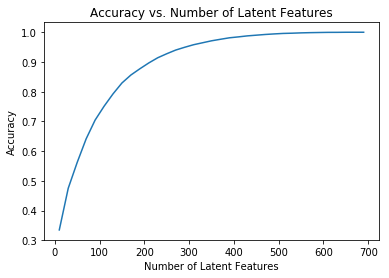

In [41]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` 通过上述单元格，我们无法判断要使用多少个潜在特征，因为能够更好地预测矩阵的 1 和 0 值，并不表明我们就能做出很好的推荐。我们可以将数据集划分为训练集和测试集，如以下单元格所示。  

根据第三个问题的代码判断，不同的潜在特征数量对训练集和测试集的准确率有何影响。使用以下划分方法： 

* 我们可以对测试集中的多少个用户做出预测？  
* 由于冷启动问题，我们无法对多少个用户做出预测？
* 我们可以对测试集中的多少篇文章做出预测？  
* 由于冷启动问题，我们无法对多少篇文章做出预测？

In [42]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [43]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [44]:
train_index = user_item_train.index
common_ids = len(set(train_index)&set(test_idx))
print('1:{}'.format(common_ids))
print('2: {}'.format(user_item_test.shape[0]-common_ids))

1:20
2: 662


In [45]:
train_columns = user_item_train.columns
common_art = len(set(train_columns)&set(test_arts))
print('3:{}'.format(common_art))
print('4:{}'.format(user_item_test.shape[1]-common_art))

3:574
4:0


In [46]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` 现在对上述 **user_item_train** 数据集进行奇异值分解，并得出 U、S 和 V 转置矩阵。然后判断在使用不同的潜在特征数量时，可以使用此矩阵分解方法对 **user_item_test** 数据集中的多少行做出预测，并根据测试数据的准确率确定应该保留多少个潜在特征。这个问题需要运用在第 `2` - `4`.个问题中完成的步骤。

通过以下单元格了解 SVD 在测试数据上做出推荐预测的效果如何。

In [47]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [48]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

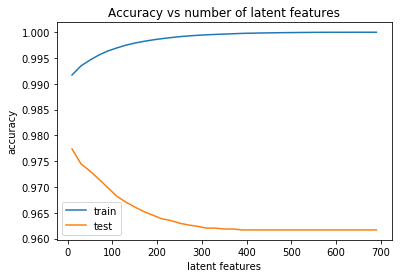

In [49]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
common_idx = set(train_index)&set(test_idx)
train_common_idx = user_item_train.index.isin(test_idx)
train_common_col = user_item_train.columns.isin(test_arts)
u_test = u_train[train_common_idx, :]
vt_test= vt_train[:, train_common_col]
user_item_test = user_item_test.loc[common_idx]

sum_train_errs = []
sum_test_errs = []
num_latent_feat=np.arange(10,710,20)

for k in num_latent_feat: 
    u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k,:]
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_idx, :], user_item_test_preds)
    train_err = np.sum(np.sum(np.abs(diffs_train))) 
    sum_train_errs.append(train_err)
    test_err = np.sum(np.sum(np.abs(diffs_test))) 
    sum_test_errs.append(test_err)
    
plt.plot(num_latent_feat, 1 - (np.array(sum_train_errs)/(user_item_train.shape[0]*user_item_train.shape[1])), label='train')
plt.plot(num_latent_feat, 1 - (np.array(sum_test_errs)/(user_item_test.shape[0]*user_item_test.shape[1])), label='test')
plt.xlabel('latent features')
plt.ylabel('accuracy')
plt.title('Accuracy vs number of latent features')
plt.legend(loc='best');



`6.` 在以下单元格中解释上个问题的结果。根据你得出的结果，讨论下你会如何判断上述推荐系统是否比用户目前查找文章的方式更好。 

**从图中可以看出，训练集的准确率随着潜在特征的增加而上升但是测试集的指标反而下降，这是一个过拟合的问题，这个模型在未知的数据预测上表现不太好，我觉得一个是因为我们的训练数据集量太小，还有一个原因是我们的矩阵非常稀疏，所以我想用少一点的潜在特征效果会比较好。根据结果来看，我不太推荐这个SVD推荐系统模型。**

<a id='conclusions'></a>






